In [1]:
import numpy as np
import PIL
import torch
from matplotlib import pyplot as plt
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb

import sys
sys.path.append('../src')
from model import MainModel


In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [4]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


def build_res_unet(n_input=1, n_output=2, size=256):
    body = create_body(resnet18(), pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(DEVICE)
    return net_G

model initialized with norm initialization


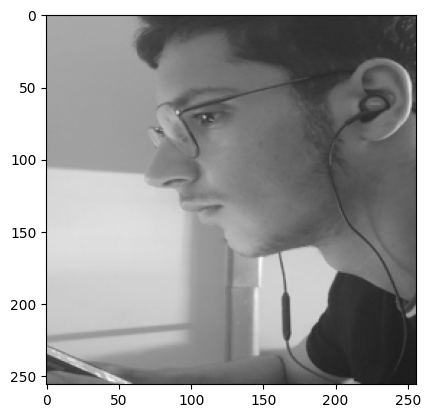

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
model.load_state_dict(
    torch.load(
        "final_model_weights.pt",
        map_location=device
    )
)
path = "D:\\AIDS\\S2\\Project\\coco-2017-dataset\\coco2017\\test2017\\abdenour.jpg"
img = PIL.Image.open(path)
img = img.resize((256, 256))
plt.imshow(img)

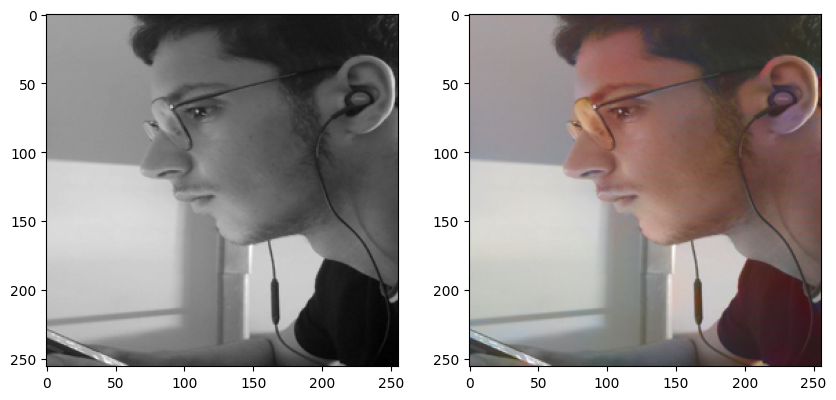

In [12]:
# to make it between -1 and 1
img = transforms.ToTensor()(img)[:1] * 2. - 1.
model.eval()
with torch.no_grad():
    preds = model.net_G(img.unsqueeze(0).to(DEVICE))
colorized = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
#show side by side with original
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(colorized)


In [13]:
img

tensor([[[ 0.3333,  0.3333,  0.3333,  ..., -0.5529, -0.5059, -0.4745],
         [ 0.3333,  0.3412,  0.3412,  ..., -0.5059, -0.4510, -0.4196],
         [ 0.3255,  0.3255,  0.3333,  ..., -0.4353, -0.3333, -0.3569],
         ...,
         [-0.0588, -0.0745, -0.0745,  ..., -0.7725, -0.7647, -0.7725],
         [-0.1059, -0.1059, -0.0902,  ..., -0.7725, -0.7647, -0.7725],
         [-0.1451, -0.1451, -0.1373,  ..., -0.7569, -0.7804, -0.7725]]])

In [24]:
#load normal_gan.csv from histories folder
import pandas as pd
#read all cv files at ./histories/Normal GAN/Val and combine them into one
#i goes from 10 to 100 with step 10
for i in range(10, 101, 10):
    df = pd.read_csv(f"../histories/Normal GAN/Val/v_normal-gan-{i}ep.csv") 
    #drop Unnamed: 0 column
    df = df.drop(columns=['Unnamed: 0'])
    for j in range(0, 10):
        #change epoch value for ex if i = 20, then epochs should become 0->11, 1->12, 2->13, ..., 10->20
        df['epoch'] = df['epoch'].replace(j, j+i-10)

    if i == 10:
        normal_gan = df
    else:
        normal_gan = pd.concat([normal_gan, df])
        normal_gan.to_csv("../histories/Normal GAN/Val/normal_gan.csv", index=False)

In [ ]:
from kornia.metrics import psnr

